In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
# import matplotlib
# import matplotlib.pyplot as plt
# plt.style.use("ggplot")

# # matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import cv2
print("Imported Tensorflow")

Imported Tensorflow


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = '/content/drive/My Drive/NN_Project_2/AerialData/TrainImages'
TRAIN_MASK_PATH = '/content/drive/My Drive/NN_Project_2/AerialData/TrainMasks'
TEST_PATH = '/content/drive/My Drive/NN_Project_2/AerialData/TestImages'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

print("Imported all the dependencies")

Imported all the dependencies


In [4]:
data_train_path = [os.path.join(pth, f) for pth, dirs, files in os.walk(TRAIN_PATH) for f in files]

In [5]:
len(data_train_path)

1050

In [12]:
 data_train_mask_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(TRAIN_MASK_PATH) for f in files]
data_test_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(TEST_PATH) for f in files]

In [7]:
len(data_test_paths)

50

In [13]:
 print(data_train_mask_paths[10])

/content/drive/My Drive/NN_Project_2/AerialData/TrainMasks/0217_mask.png


In [9]:
print(data_train_path[10])

/content/drive/My Drive/NN_Project_2/AerialData/TrainImages/0183_img.png


In [11]:
print(data_train_path[10][:-7])

/content/drive/My Drive/NN_Project_2/AerialData/TrainImages/0183_


In [14]:
print(data_train_path[10][-11:-7])

183_


In [21]:
a = TRAIN_MASK_PATH+data_train_path[10][-13:-7]+"mask.png"

In [22]:
a

'/content/drive/My Drive/NN_Project_2/AerialData/TrainMasks/0183_mask.png'

In [23]:
# Get train and test IDs


# Get and resize train images and masks
X_train = np.zeros((len(data_train_path), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(data_train_mask_paths), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
n = 0
for i in tqdm(range(0,len(data_train_path))):
	# path = TRAIN_PATH + id_
  img = imread(data_train_path[i])[:,:,:IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[i] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  path = TRAIN_MASK_PATH+data_train_path[i][-13:-7]+"mask.png"
  mask_ = imread(path)
  mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
  mask = np.maximum(mask, mask_)
  Y_train[i] = mask

print('Done!')
	


X_train (1050, 128, 128, 3)
Y_train (1050, 128, 128, 1)
Getting and resizing train images and masks ... 


100%|██████████| 1050/1050 [06:29<00:00,  2.69it/s]

Done!


In [24]:
# Get and resize test images
X_test = np.zeros((len(data_test_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for i in tqdm(range(0,len(data_test_paths))):
    img = imread(data_test_paths[i])[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[i] = img

Getting and resizing test images ... 


100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


1030


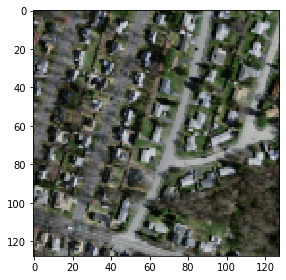

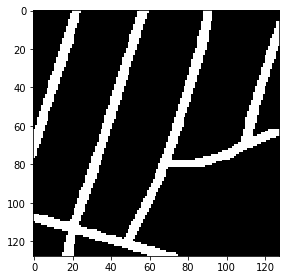

<Figure size 432x288 with 0 Axes>

In [34]:
# Check if training data looks all right
ix = random.randint(0, len(X_train))
print(ix)
imshow(X_train[ix])
plt.show();
plt.savefig('img.png')

imshow(np.squeeze(Y_train[ix]))
plt.show();
plt.savefig('mask.png')

In [32]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        # y_pred_ = tf.to_int32(y_pred > t) 
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [47]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mean_iou'])
model.summary()
print("The model is defined")

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128, 128, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 128, 128, 16) 448         lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_43 (Dropout)            (None, 128, 128, 16) 0           conv2d_91[0][0]                  
______________________________________________________________________________________

In [38]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50)
                    




Epoch 1/50
60/60 [==============================] - 163s 3s/step - loss: 0.2942 - accuracy: 0.9064 - val_loss: 0.3533 - val_accuracy: 0.9005
Epoch 2/50
60/60 [==============================] - 162s 3s/step - loss: 0.2353 - accuracy: 0.9176 - val_loss: 0.2603 - val_accuracy: 0.8999
Epoch 3/50
60/60 [==============================] - 162s 3s/step - loss: 0.2271 - accuracy: 0.9178 - val_loss: 0.3107 - val_accuracy: 0.9009
Epoch 4/50
60/60 [==============================] - 162s 3s/step - loss: 0.2075 - accuracy: 0.9216 - val_loss: 0.2588 - val_accuracy: 0.9049
Epoch 5/50
60/60 [==============================] - 163s 3s/step - loss: 0.1917 - accuracy: 0.9279 - val_loss: 0.2336 - val_accuracy: 0.9110
Epoch 6/50
60/60 [==============================] - 162s 3s/step - loss: 0.1759 - accuracy: 0.9345 - val_loss: 0.2300 - val_accuracy: 0.9153
Epoch 7/50
60/60 [==============================] - 163s 3s/step - loss: 0.1667 - accuracy: 0.9392 - val_loss: 0.1995 - val_accuracy: 0.9262
Epoch 8/50
60

OSError: ignored

2/2 [==============================] - 1s 403ms/step


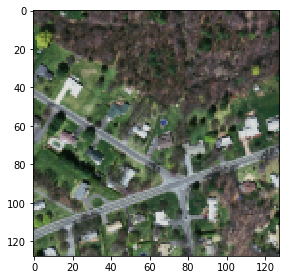

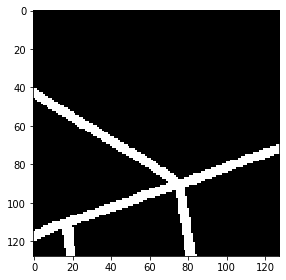

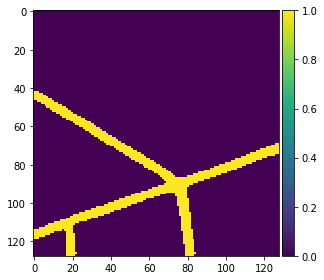

<Figure size 432x288 with 0 Axes>

In [39]:
#Predict on train, val and test
# model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show();
plt.savefig('img.png')
imshow(np.squeeze(Y_train[ix]))
plt.show();
plt.savefig('gt.png')
imshow(np.squeeze(preds_train_t[ix]))
plt.show();
plt.savefig('predict.png')

In [40]:
import sys, time

def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

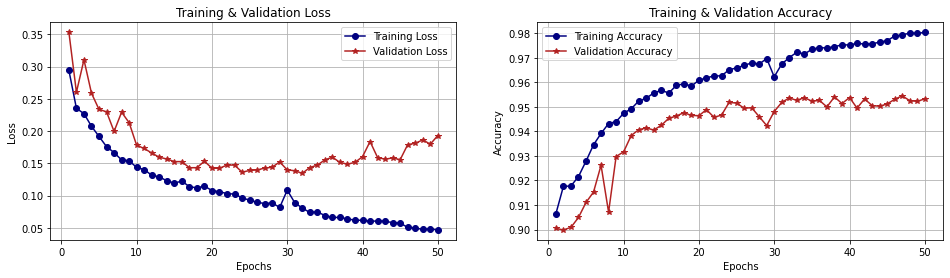

In [41]:
show_plots(results.history)

In [42]:
# Build 14 Layer U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
# c5 = Dropout(0.3) (c5)
# c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c4)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# c6 = Dropout(0.2) (c6)
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

simplified_model = Model(inputs=[inputs], outputs=[outputs])
simplified_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
simplified_model.summary()
print("The simplified model is defined")

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 128, 128, 16) 0           conv2d_57[0][0]                  
_______________________________________________________________________________________

Epoch 1/50
60/60 [==============================] - 139s 2s/step - loss: 0.2758 - accuracy: 0.9114 - val_loss: 0.2847 - val_accuracy: 0.9004
Epoch 2/50
60/60 [==============================] - 140s 2s/step - loss: 0.2273 - accuracy: 0.9181 - val_loss: 0.2605 - val_accuracy: 0.8886
Epoch 3/50
60/60 [==============================] - 144s 2s/step - loss: 0.2010 - accuracy: 0.9241 - val_loss: 0.3268 - val_accuracy: 0.9084
Epoch 4/50
60/60 [==============================] - 140s 2s/step - loss: 0.1781 - accuracy: 0.9344 - val_loss: 0.2003 - val_accuracy: 0.9218
Epoch 5/50
60/60 [==============================] - 140s 2s/step - loss: 0.1628 - accuracy: 0.9410 - val_loss: 0.2001 - val_accuracy: 0.9236
Epoch 6/50
60/60 [==============================] - 140s 2s/step - loss: 0.1516 - accuracy: 0.9450 - val_loss: 0.1797 - val_accuracy: 0.9293
Epoch 7/50
60/60 [==============================] - 144s 2s/step - loss: 0.1450 - accuracy: 0.9477 - val_loss: 0.1731 - val_accuracy: 0.9354
Epoch 8/50
60

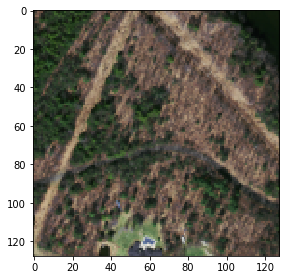

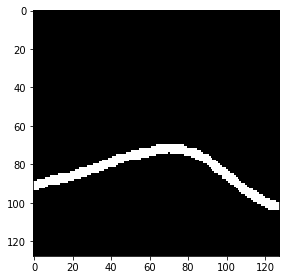

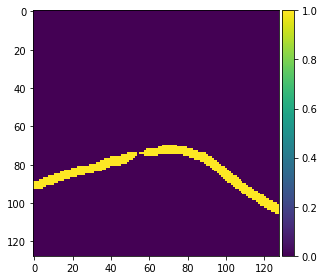

<Figure size 432x288 with 0 Axes>

In [43]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('simplified_model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

results = simplified_model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50)
                    

#Predict on train, val and test
# simplified_model = load_model('simplified_model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = simplified_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = simplified_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = simplified_model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show();
plt.savefig('img.png')
imshow(np.squeeze(Y_train[ix]))
plt.show();
plt.savefig('gt.png')
imshow(np.squeeze(preds_train_t[ix]))
plt.show();
plt.savefig('predict.png')


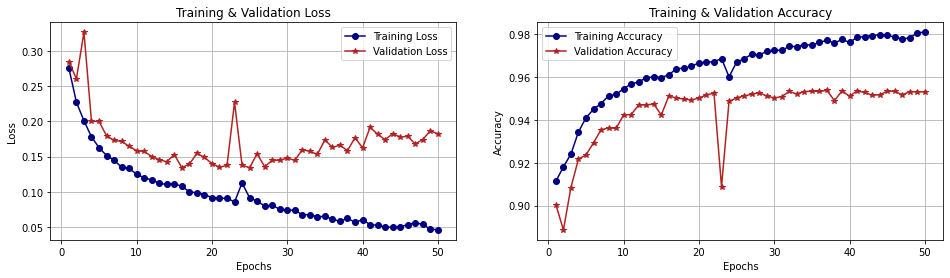

In [44]:
show_plots(results.history)

https://github.com/zhixuhao/unet/blob/master/model.py

U-NET Base Model